In [1]:
%load_ext autoreload
%autoreload 2
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

import random
import matplotlib.pyplot as plt

import chex
import jax
import flax
import torch
import optax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from einops import rearrange
from flax.training import train_state, checkpoints

from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import GNNBenchmarkDataset, TUDataset

from src import get_nparams, get_graph, to_device_split, init_model, train_loop, eval_nfold, eval_loop

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Callable
from functools import partial
import jax.experimental.sparse as jsparse
from optax._src.loss import smooth_labels, softmax_cross_entropy

smooth_labels = jax.vmap(partial(smooth_labels, alpha=0.05))
softmax_cross_entropy = jax.vmap(partial(softmax_cross_entropy))

@jax.vmap
def Accuracy(preds: jnp.ndarray, targets: jnp.ndarray):
    chex.assert_equal_shape((preds, targets))
    return (preds == targets).mean()


@jax.vmap
def l2_loss(preds: jnp.ndarray, targets: jnp.ndarray):
    chex.assert_equal_shape((preds, targets))
    return jnp.square(preds - targets).sum() / jnp.count_nonzero(targets)
    

def compute_loss(
    params,
    data: dict,
    apply_fn: Callable,
    kclasses: int,
    to_device: bool,
    **kwargs
):
    
    labels = data.pop('Y')
    
    # CLS, X, A, stats
    results = apply_fn({'params': params}, data['X'], data['A'], data['P'], data['key'], False, True)
    
    logits = results['CLS']
    
    loss = softmax_cross_entropy(
        logits, 
        smooth_labels(jax.nn.one_hot(labels, kclasses))
    ).mean() + l2_loss(results['A'], data['A']).mean()
        
    accuracy = Accuracy(jnp.argmax(logits, axis=-1).squeeze(), labels).mean()
        
    if to_device:
        loss, accuracy = map(lambda x : jax.lax.pmean(x, 'batch'), (loss, accuracy))
        
    return loss, accuracy

In [3]:
model_name = data_name = 'MNIST'
saved_dir = "./saved_models/" + model_name
path = './stats/' + model_name + '_stats.npy'

batch_size = 128 * len(jax.local_devices())

train_data = GNNBenchmarkDataset(root = '../data/', name = data_name, split = 'train')
test_data = GNNBenchmarkDataset(root = '../data/', name = data_name, split = 'test')
valid_data = GNNBenchmarkDataset(root = '../data/', name = data_name, split = 'val')

In [4]:
from src import GraphImageET as GraphET

k = 15                       # N x k pos_embedding dim we want to use (2 * k if we use svd)
kclasses = 10                # output dim
embed_type = 'eigen'         # pos_embedding type
task_level = 'graph'         # graph or node level 
to_device = True
max_num_nodes = 500

model = GraphET(
    embed_dim = 128,
    out_dim = kclasses, 
    nheads = 12,
    alpha = 0.25,
    depth = 4,
    block = 2,
    head_dim = 64,
    multiplier = 4.,
    dtype = jnp.float32,
    kernel_size = [3, 3],
    kernel_dilation = [1, 1],
    compute_corr = True,
    vary_noise = False,
    chn_atype = 'relu',
    noise_std = 0.02,
)

key = jax.random.PRNGKey(42)

params = init_model(
    DataLoader(train_data, batch_size = 1), key, model, k, embed_type, task_level)

print("PARAMS COUNT:", get_nparams(params))

PARAMS COUNT: 528980


In [5]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
key, _ = jax.random.split(key)
g.manual_seed(3407 + int(jnp.mean(key)))

train_loader, valid_loader, test_loader = map(
    lambda x : DataLoader(x, shuffle = True, batch_size = batch_size, worker_init_fn = seed_worker, generator = g), 
    (train_data, valid_data, test_data)
)

In [6]:
epochs = 150

warmup_steps = 50 * len(train_loader) 
total_steps = len(train_loader) * epochs

scheduler = optax.warmup_cosine_decay_schedule(
    init_value = 1e-3,
    peak_value = 1e-3,
    warmup_steps = warmup_steps,
    decay_steps = total_steps,
    end_value = 5e-5,
)

optimizer = optax.chain(
    optax.centralize(),
    optax.adamw(
        learning_rate = scheduler, 
        weight_decay=0.05,
        b1=0.9,
        b2=0.99,
    ),
)    

state = train_state.TrainState.create(apply_fn = model.apply, params = params, tx = optimizer)
state = checkpoints.restore_checkpoint(ckpt_dir = saved_dir, target = state)

if to_device:
    state = flax.jax_utils.replicate(state)

In [7]:
train_compute_loss = partial(compute_loss, to_device=False, kclasses=kclasses, apply_fn=state.apply_fn)

valid_compute_loss = jax.pmap(
    partial(compute_loss, to_device=to_device, kclasses=kclasses, apply_fn=state.apply_fn),
    axis_name='batch',
    in_axes=(0, {'X': 0, 'Y': 0, 'P': 0, 'A': 0, 'key': 0})
)

get_train_data = partial(
    get_graph, 
    max_num_nodes = max_num_nodes, 
    k = k, 
    embed_type = embed_type,
    task_level = task_level,
    to_device = to_device,
    flip_sign = True,
)
 
get_valid_data = partial(
    get_graph, 
    max_num_nodes = max_num_nodes, 
    k = k, 
    embed_type = embed_type,
    task_level = task_level,
    to_device = to_device,
    flip_sign = False,
)

In [8]:
key, state = train_loop(
    state, 
    {'train': train_loader, 'valid': valid_loader},
    {'train': get_train_data, 'valid': get_valid_data},
    train_compute_loss,
    valid_compute_loss,
    epochs,
    path = path
)

print("Total epochs:", jnp.mean(state.step / len(train_loader)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [3:45:57<00:00, 90.38s/it, train_accuracy=0.982, train_loss=0.358, val_accuracy=0.971, val_loss=0.385]


Saved statistics to ./stats/MNIST_stats.npy
Total epochs: 150.0


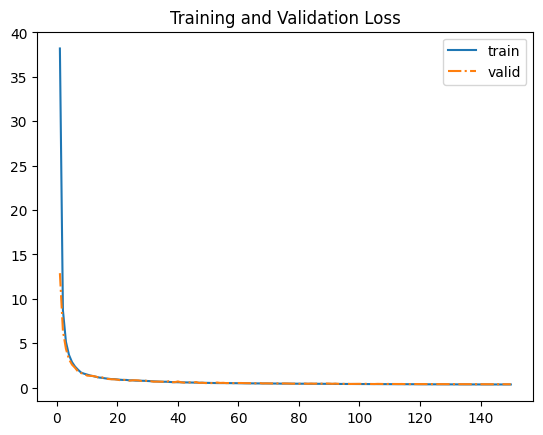

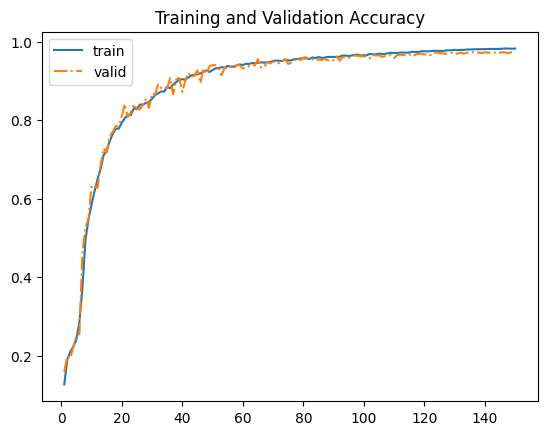

'saved_models/MNIST/checkpoint_16200'

In [9]:
# 4 columns: train-loss train-accuracy valid-loss valid-accuracy
stats = np.loadtxt(path)

if len(stats.shape) == 1:
    stats = stats[None]

train_loss, valid_loss = stats[:, 0], stats[:, 2]
train_accuracy, valid_accuracy = stats[:, 1], stats[:, 3]

# total epochs
xlimit = np.arange(1, stats.shape[0] + 1)

plt.title('Training and Validation Loss')
plt.plot(xlimit, train_loss, label = 'train')
plt.plot(xlimit, valid_loss, '-.', label = 'valid')
plt.legend()
plt.show()

plt.title('Training and Validation Accuracy')
plt.plot(xlimit, train_accuracy, label = 'train')
plt.plot(xlimit, valid_accuracy, '-.', label = 'valid')
plt.legend()
plt.show()

if to_device:
    state = flax.jax_utils.unreplicate(state)
    to_device = False

checkpoints.save_checkpoint(ckpt_dir = saved_dir, target = state, overwrite = True, step = epochs * len(train_loader))